In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn import model_selection, preprocessing

In [2]:
from tensorflow.keras import activations, datasets, layers, losses, metrics, models, backend, regularizers
import tensorview as tv
import tensorflow as tf

In [3]:
import lightgbm

In [4]:
import folium

In [5]:
import utm

## Load train and test data

In [6]:
# train set
df_mess_train = pd.read_csv('mess_train_list.csv')

# test set
df_mess_test = pd.read_csv('mess_test_list.csv')

# position associated to train set
pos_train = pd.read_csv('pos_train_list.csv') 

In [7]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [8]:
df_mess_train['did'].unique().shape

(113,)

In [9]:
print(df_mess_train.shape)
df_mess_train.describe()

(39250, 8)


,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [10]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [11]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


## Prepare data

In [12]:
# determine all Base stations that received at least 1 message
trainBs  = np.unique(df_mess_train['bsid'])
testBs   = np.unique(df_mess_test['bsid'])
listOfBs = np.union1d(trainBs, testBs) 
testOnlyBs = np.lib.arraysetops.setdiff1d(testBs, trainBs)

print(f"Number of stations: %d, test only %d" % (len(listOfBs), len(testOnlyBs)))

Number of stations: 259, test only 8


In [13]:
df_mess_train['did'].unique().shape

(113,)

# Affichage des données

## Passage en UTM

In [14]:

def latlon_to_xy(lat, lon):
    """Conversion lat/lon en UTM"""
    x, y, utm_zone, utm_letter = utm.from_latlon(lat, lon)
    return x, y, utm_zone, utm_letter


def xy_to_latlon(x, y, utm_zone, utm_letter):
    """Conversion UTM en lat/lon"""
    lat, lon = utm.from_latlon(x, y, utm_zone, utm_letter)
    return lat, lon


pos_train[['x', 'y', 'utm_zone', 'utm_letter']] = pos_train.apply(lambda row: pd.Series(latlon_to_xy(row['lat'], row['lng'])),axis=1)
df_mess_train[['bs_x', 'bs_y', 'bs_utm_zone', 'bs_utm_letter']] = df_mess_train.apply(lambda row: pd.Series(latlon_to_xy(row['bs_lat'], row['bs_lng'])),axis=1)
df_mess_test[['bs_x', 'bs_y', 'bs_utm_zone', 'bs_utm_letter']] = df_mess_test.apply(lambda row: pd.Series(latlon_to_xy(row['bs_lat'], row['bs_lng'])),axis=1)

## Filtering on outliers


In [15]:
print(f"Nombres de messages du jeu d'apprentissage: {len(df_mess_train.messid.unique())}");
print(f"Nombres de messages du jeu d'apprentissage sans les stations au dessus du 60eme parallèle : {len(df_mess_train[df_mess_train.bs_lat<60].messid.unique())}");

Nombres de messages du jeu d'apprentissage: 6068
Nombres de messages du jeu d'apprentissage sans les stations au dessus du 60eme parallèle : 5918


In [16]:
print(f"Nombres de messages du jeu de: {len(df_mess_test.messid.unique())}");
print(f"Nombres de messages du jeu de test sans les stations au dessus du 60eme parallèle : {len(df_mess_test[df_mess_test.bs_lat<60].messid.unique())}");

Nombres de messages du jeu de: 5294
Nombres de messages du jeu de test sans les stations au dessus du 60eme parallèle : 5199


### Analyse
On a 150 messages du jeu d'apprentissage et 95 du jeu de test qui refère uniquement les stations au dessus du 60eme parallèle.
Ces stations sont très éloignés des autres données et semblent donc être des données anomaliques.
En analysant les coordonnées des labels pour ces messages, ils s'avèrent que les devices sont tous situé dans la zone des autres stations.
Nous prenons donc le parti de modifier les coordonnées de ces stations au barycentre des différentes positions des devices qui ont communiqué uniquement avec ces stations.

In [17]:
mask = ~df_mess_train[df_mess_train.bs_lat > 60]["messid"].isin(df_mess_train[df_mess_train.bs_lat < 60]["messid"])
messid_far = df_mess_train[df_mess_train.bs_lat > 60]["messid"][mask].unique()
df_contat = pd.concat([df_mess_train,pos_train], axis=1)
zone_19_stations = df_contat[df_contat["messid"].isin(messid_far)]
zone_19_coords = zone_19_stations.mean(axis=0)[["lat", "lng", "x","y","utm_zone"]]

mask_19 = df_mess_train["bs_utm_zone"]!=19
df_mess_train.bs_lat = df_mess_train.bs_lat.where(mask_19, other=zone_19_coords.lat)
df_mess_train.bs_lng = df_mess_train.bs_lng.where(mask_19, other=zone_19_coords.lng)
df_mess_train.bs_x = df_mess_train.bs_x.where(mask_19, other=zone_19_coords.x)
df_mess_train.bs_y = df_mess_train.bs_y.where(mask_19, other=zone_19_coords.y)
df_mess_train.bs_utm_zone = df_mess_train.bs_utm_zone.where(mask_19, other=zone_19_coords.utm_zone)
df_mess_train.bs_utm_letter = df_mess_train.bs_utm_letter.where(mask_19, other="S")


In [18]:
mask_19 = df_mess_test["bs_utm_zone"]!=19
df_mess_test.bs_lat = df_mess_test.bs_lat.where(mask_19, other=zone_19_coords.lat)
df_mess_test.bs_lng = df_mess_test.bs_lng.where(mask_19, other=zone_19_coords.lng)
df_mess_test.bs_x = df_mess_test.bs_x.where(mask_19, other=zone_19_coords.x)
df_mess_test.bs_y = df_mess_test.bs_y.where(mask_19, other=zone_19_coords.y)
df_mess_test.bs_utm_zone = df_mess_test.bs_utm_zone.where(mask_19, other=zone_19_coords.utm_zone)
df_mess_test.bs_utm_letter = df_mess_test.bs_utm_letter.where(mask_19, other="S")


In [19]:
df_mess_train

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,bs_x,bs_y,bs_utm_zone,bs_utm_letter
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917,503869.635594,4.385338e+06,13,S
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721,504054.699417,4.391937e+06,13,S
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827,499242.327010,4.384777e+06,13,S
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.000000,1.463553e+12,39.797969,-105.073460,493710.997974,4.405337e+06,13,S
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.000000,1.463553e+12,39.723151,-104.956216,503752.467865,4.397031e+06,13,S
...,...,...,...,...,...,...,...,...,...,...,...,...
39245,5848672e12f14360d7942374,3410,476257.0,1.0,-128.000000,1.481140e+12,39.777690,-105.002424,499792.390739,4.403083e+06,13,S
39246,5848672e12f14360d7942374,8352,476257.0,0.0,-121.000000,1.481140e+12,39.761633,-105.025753,497794.111630,4.401302e+06,13,S
39247,5848672e12f14360d7942374,8397,476257.0,2.0,-126.000000,1.481140e+12,39.759396,-105.001415,499878.787174,4.401053e+06,13,S
39248,58487473e541cd0e133cca72,3051,476593.0,1.0,-131.333333,1.481143e+12,39.898872,-105.153832,486849.579779,4.416544e+06,13,S


## Construction de la matrice des featues
Pour cette matrice, nous n'utiliserons qu'une partie des données et nous ferons une moyenne geometrique sur les coordonnées des devices

In [63]:
def feat_mat_const(df, listOfBs, keepMax=5):
    """ Feature Matrix construction """
    
    aggCols = ['did', 'pivot_lat', 'pivot_lng']
    for i in range(keepMax):
        bsCols =['bs%d_deltalat' % i, 'bs%d_deltalng' % i, 'bs%d_rssi' % i] #, 'bs%d_nseq' % i 'bs%d_active' % i, 
        aggCols = aggCols + bsCols
        
    def aggregateBaseStations(groupBy):
        """ From a RSSI sorted DataFrameGroupBy
            create a dataframe with the 3 best BS 
        """
        
        did = groupBy['did'][0]
        bsSet = groupBy.iloc[:keepMax]
            
        # Barycentre par moyenne geometrique
        w_geom = np.exp(bsSet['rssi']) / np.sum(np.exp(bsSet['rssi']))
        
        x_geom = np.exp(np.sum(w_geom * np.log(bsSet['bs_x'])) / np.sum(w_geom))
        y_geom = np.exp(np.sum(w_geom * np.log(bsSet['bs_y'])) / np.sum(w_geom))
        
        # Barycentre par moyenne arithmétique
        w_arm = bsSet['rssi'] / np.sum(bsSet['rssi'])
        
        x_arm = np.average(bsSet['bs_x'], weights=w_arm)
        y_arm = np.average(bsSet['bs_y'], weights=w_arm)
        
        bss = []
        for i in range(keepMax):
            if len(bsSet) > i:
                b = bsSet.iloc[i]
                dx = b['bs_x'] - x_geom
                dy = b['bs_y'] - y_geom
                bss.append([dy, dx, b['rssi']])
            else:
                bss.append([0, 0, -1e3])
        return pd.DataFrame(np.concatenate([[did, y_geom, x_geom], np.array(bss).ravel()]).reshape(1, -1), 
                            columns=aggCols)
            
    
    # Keep at max keepMax base-stations per message
    df = df.groupby('messid'). \
        apply(lambda x: x.sort_values(['rssi'], ascending=False)). \
        reset_index(drop=True).groupby('messid').apply(aggregateBaseStations)
    
    return df

In [64]:
def ground_truth_const(df_mess_train, pos_train):
    """ Ground truth construction """
    
    df = pd.concat([df_mess_train[['messid']], pos_train], axis=1)
    df_mean = df.groupby('messid').mean()

    return df_mean['y'], df_mean['x']

In [65]:
df_feat = feat_mat_const(df_mess_train, listOfBs, 5)
print(df_feat.shape)
df_feat.head()

(6068, 18)


,,did,pivot_lat,pivot_lng,bs0_deltalat,bs0_deltalng,bs0_rssi,bs1_deltalat,bs1_deltalng,bs1_rssi,bs2_deltalat,bs2_deltalng,bs2_rssi,bs3_deltalat,bs3_deltalng,bs3_rssi,bs4_deltalat,bs4_deltalng,bs4_rssi
messid,,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,0,473335.0,4.385532e+06,503875.059261,-1.932865e+02,-5.423667e+00,-121.500000,6405.584046,179.640156,-125.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0
573bf3533e952e19126b256a,0,473335.0,4.384777e+06,499242.327010,3.725290e-09,-2.328306e-10,-134.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0
573c0cd0f0fe6e735a699b93,0,473953.0,4.398018e+06,502257.923840,2.033077e-06,-3.075635e-06,-100.000000,-986.550840,1494.544025,-120.000000,7318.848418,-8546.925867,-132.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0
573c1272f0fe6e735a6cb8bd,0,476512.0,4.392668e+06,497617.210698,2.335382e+03,9.775454e+02,-123.333333,-3235.797476,-1364.889089,-123.666667,-7891.007033,1625.116312,-129.666667,-20932.262557,-2183.741877,-133.000000,0.000000,0.000000,-1000.0
573c8ea8864fce1a9a5fbf7a,0,476286.0,4.400569e+06,496289.728728,-2.606393e-01,-2.428322e-01,-98.000000,733.222531,1504.382903,-106.666667,2934.604628,219.650015,-108.000000,41.528627,-1121.676250,-108.666667,1874.057762,2903.862033,-114.0


In [66]:
ground_truth_y, ground_truth_x = ground_truth_const(df_mess_train, pos_train)
ground_truth_y.shape

(6068,)

In [67]:
df_feat_red = df_feat.drop('did', axis=1)

## Evaluate helpers

In [25]:
def vincenty_vec(vec_coord):
    """ Now using geodesic distance instead of Vincenty """
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] != 4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [geodesic(v[0:2], v[2:]).meters for v in vec_coord]

    return vin_vec_dist

In [26]:
def eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    """ Evaluate distance error for each predicted point """
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [27]:
def plotError(err_vec):
    """ Plot error cumulative distribution and the 80 quantile """
    
    err80 = np.percentile(err_vec, 80)
    
    print(f"error @ 80% = {err80:.1f} m")
    
    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values) 

    plt.figure()
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0,
             label="Opt LLR", c='blue')

    # plot error @ 80%
    plt.axvline(x=err80/1000., ymin=0, ymax=100,
                linestyle='dashed', color='red')

    plt.xlabel('Distance Error (km)')
    plt.ylabel('Cum proba (%)')
    plt.axis([0, 30, 0, 100]) 

    plt.title('Error Cumulative Probability')
    plt.legend()

    plt.grid()

# Deep neural Network

In [68]:
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(df_feat_red.values, 
                                                                np.c_[ground_truth_y.values, ground_truth_x.values], 
                                                                test_size=0.1)
# Normalize data to get proper network optimization
scaleX = preprocessing.StandardScaler()
scaleX.fit(xtrain)
xtrain = scaleX.transform(xtrain)
xtest = scaleX.transform(xtest)

scaleY = preprocessing.StandardScaler()
scaleY.fit(ytrain)
ytrain = scaleY.transform(ytrain)
# NO ytest = scaleY.transform(ytest)

In [69]:
model1 = models.Sequential([
    layers.Dense(128, name='dense_1', activation=activations.relu, input_shape=[df_feat_red.shape[1]]),
    layers.Dropout(0.01),
    layers.Dense(32, name='dense_2', activation=activations.relu),
   #  layers.Dropout(0.01),
    layers.Dense(2, name='dense_3', activation=activations.linear),
])

model1.compile(optimizer='adam',
          loss=losses.MeanSquaredError())
    
model1.summary()

metricNames = ['Loss']

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2304      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 6,498
Trainable params: 6,498
Non-trainable params: 0
_________________________________________________________________


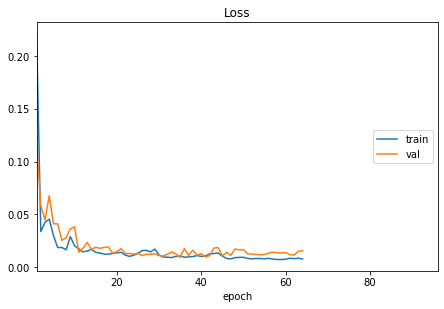

In [ ]:
nEpochs = 96
batchSize = 64

tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=1)

history1 = model1.fit(xtrain, ytrain,
            epochs=nEpochs, batch_size=batchSize, 
            validation_split=0.1, 
            verbose=0,
            callbacks=[tvPlot]);

In [ ]:
weights1 = model1.get_weights()
plt.hist(weights1[0].ravel(), bins=30);

In [ ]:
yEst = model1.predict(xtest)
yEst = scaleY.inverse_transform(yEst)

In [ ]:
metrics.mean_squared_error(ytest[:,0], yEst[:,0]).numpy(), \
metrics.mean_squared_error(ytest[:,1], yEst[:,1]).numpy()

In [ ]:
#dnnErr_vec = eval_geoloc(ytest[:,0], ytest[:,1], yEst[:,0].reshape(-1), yEst[:,1].reshape(-1))
#plotError(dnnErr_vec)

# The coordinates are in true X,Y for distance computation
delta_y = yEst[:,0] - ytest[:,0]
delta_x = yEst[:,1] - ytest[:,1]


dnnErr_vec = np.sqrt(delta_x**2 + delta_y**2)

plotError(dnnErr_vec)

## DNN with leave out device K fold validation

Utilisation de GroupKFold de Scikit Learn, génère K fold en évitant que les éléments d'un groupe se trouvent dans le train et la valid

In [36]:
gkl1o = model_selection.GroupKFold(24) #model_selection.LeaveOneGroupOut()

In [37]:
scaleX = preprocessing.StandardScaler()
scaleX.fit(df_feat_red)
df_feat_scaled = scaleX.transform(df_feat_red)

y = np.c_[ground_truth_y.values, ground_truth_x.values]
scaleY = preprocessing.StandardScaler()
scaleY.fit(y)
yscaled = scaleY.transform(y)

In [40]:
i = 0
errors80Dnn = []
nEpochs = 96
for train, val in gkl1o.split(df_feat, groups=df_feat['did']):
    
    i+=1
    if i % 4 == 0: print('Split #', i)  
    
    xtrain = df_feat_scaled[train]
    xval = df_feat_scaled[val]
    ytrain = yscaled[train]
    yval = yscaled[val]
    
    model1.reset_states()
    model1.fit(xtrain, ytrain,
            epochs=nEpochs, batch_size=batchSize, 
            validation_data=(xval, yval),
            verbose=0)
    yEst = model1.predict(xval)
    yEst = scaleY.inverse_transform(yEst)
    
    delta_y = yEst[:,0] - ground_truth_y[val]
    delta_x = yEst[:,1] - ground_truth_x[val]
    
    dnnErr_vec = np.sqrt(delta_x**2 + delta_y**2)
    
    #dnnErr_vec = eval_geoloc(ground_truth_lat[val], ground_truth_lng[val], yEst[:,0], yEst[:,1])
    err80 = np.percentile(dnnErr_vec, 80)
    #print('Err @ 80%%, %.1fm' % (err80))
    errors80Dnn.append(err80) 

Split # 4
Split # 8


KeyboardInterrupt: 

# LightGBM with Leave out device K fold

In [61]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 250,
    'learning_rate': 0.02,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

i = 0
didLgbm = []
errors80Lgbm = []
for train, val in gkl1o.split(df_feat, groups=df_feat['did']):
    i+=1
    if i % 4 == 0:
        print('Split #', i)
    
    xtrain = df_feat_red.values[train]
    xval = df_feat_red.values[val]
    
    lat_train = lightgbm.Dataset(xtrain, ground_truth_y[train])
    lat_valid = lightgbm.Dataset(xval, ground_truth_y[val])
    model_lat = lightgbm.train(params,
                           lat_train,
                           valid_sets=lat_valid,
                           num_boost_round=5000,
                           early_stopping_rounds=250,verbose_eval=False) 

    lng_train = lightgbm.Dataset(xtrain, ground_truth_x[train])
    lng_valid = lightgbm.Dataset(xval, ground_truth_x[val])
    model_lng = lightgbm.train(params,
                           lng_train,
                           valid_sets=lng_valid,
                           num_boost_round=5000,
                           early_stopping_rounds=250,verbose_eval=False) 

    # Evaluate
    lat_pred = model_lat.predict(xval)
    lng_pred = model_lng.predict(xval)
    
    delta_y = lat_pred - ground_truth_y[val]
    delta_x = lng_pred - ground_truth_x[val]
    
    lgbmErr_vec = np.sqrt(delta_x**2 + delta_y**2)
    #lgbmErr_vec = eval_geoloc(ground_truth_y[val], ground_truth_x[val], lat_pred, lng_pred)
    err80 = np.percentile(lgbmErr_vec, 80)
    errors80Lgbm.append(err80) 

Split # 4
Split # 8
Split # 12
Split # 16
Split # 20
Split # 24


In [ ]:
#lat_pred = model_lat.predict(xtest)
#lng_pred = model_lng.predict(xtest)
#
#lgbmErr_vec = eval_geoloc(ytest[:,0], ytest[:,1], lat_pred, lng_pred)
#plotError(lgbmErr_vec)

## Plot leave 1 device out performance

Mean error over devices @ 80%, DNN : 4647.6m, LGBM : 5410.8m


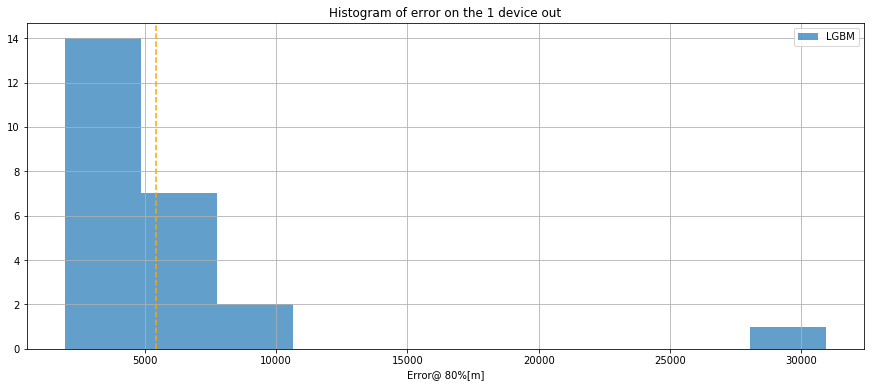

In [62]:
errorMeanOverDevicesDnn = np.array(errors80Dnn).mean()
errorMeanOverDevicesLgbm = np.array(errors80Lgbm).mean()
print('Mean error over devices @ 80%%, DNN : %.1fm, LGBM : %.1fm' % \
          (errorMeanOverDevicesDnn, errorMeanOverDevicesLgbm))
fig, ax = plt.subplots(figsize=(15, 6))
#ax.hist(errors80Dnn,  bins=5, alpha=0.7, label='DNN')
ax.hist(errors80Lgbm, bins=10, alpha=0.7, label='LGBM')
ax.set_title('Histogram of error on the 1 device out')
ax.set_xlabel('Error@ 80%[m]')
#ax.axvline(x=errorMeanOverDevicesDnn,  color='blue', linestyle='--')
ax.axvline(x=errorMeanOverDevicesLgbm, color='orange', linestyle='--')
ax.legend()
ax.grid()

## Study outliers on the error 80

Device ID=476835 a des performances très mauvaises (erreur @ 80% > 100km).

Cette section détermine les problèmes des messages de ce device

In [36]:
outlier1Did = 476835
outlier1Index = df_mess_train['did'] == outlier1Did
outlier1X = df_mess_train[outlier1Index]
outlier1X.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
17074,57c4a76fe541cd77a07a17be,3558,476835.0,1.0,-91.666667,1.472506e+12,39.810055,-105.010413
17075,57c4a76fe541cd77a07a17be,4060,476835.0,1.0,-130.000000,1.472506e+12,39.798157,-104.915073
17076,57c4a76fe541cd77a07a17be,8475,476835.0,1.0,-124.000000,1.472506e+12,39.811782,-105.026329
17086,57c4aa0612f14345918d26f0,1661,476835.0,1.0,-135.000000,1.472506e+12,64.300000,-68.500000
17087,57c4aa0612f14345918d26f0,1859,476835.0,1.0,-129.000000,1.472506e+12,39.704887,-105.016392


In [37]:
outlier1MessId = df_mess_train[outlier1Index].reset_index()['messid'].unique()
outlier1MessId.shape

(69,)

In [38]:
df_feat_rank1OutlierIndex = df_feat['did']== outlier1Did
df_feat[df_feat_rank1OutlierIndex].head(5)

,,did,pivot_lat,pivot_lng,bs0_deltalat,bs0_deltalng,bs0_rssi,bs1_deltalat,bs1_deltalng,bs1_rssi,bs2_deltalat,bs2_deltalng,bs2_rssi,bs3_deltalat,bs3_deltalng,bs3_rssi,bs4_deltalat,bs4_deltalng,bs4_rssi
messid,,,,,,,,,,,,,,,,,,,
57c4a76fe541cd77a07a17be,0,476835.0,39.806200,-104.980267,0.003855,-0.030147,-91.666667,0.005582,-0.046062,-124.000000,-0.008043,0.065194,-130.000000,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0
57c4aa0612f14345918d26f0,0,476835.0,39.791924,-105.028951,0.001661,0.010700,-110.333333,0.005782,-0.031283,-117.333333,-0.011266,-0.024726,-118.000000,0.018131,0.018537,-120.0,-0.014234,0.026526,-120.0
57c4aca6cf554f465a3baffd,0,476835.0,39.778490,-105.015787,0.003623,-0.056914,-112.000000,-0.021456,0.039660,-119.333333,-0.006575,0.006371,-120.000000,0.043182,-0.007359,-123.0,-0.019094,0.014372,-124.0
57c69d31e541cd77a0d00095,0,476835.0,39.789733,-105.063563,-0.009075,0.009887,-87.000000,0.007973,0.003329,-107.000000,-0.008269,0.022800,-109.666667,-0.006523,-0.025184,-110.0,0.014062,-0.008527,-111.0
57c69f7fcf554f465a9067a7,0,476835.0,39.805420,-105.040942,0.000000,0.000000,-125.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0


In [39]:
outlier1y = y[df_feat_rank1OutlierIndex]

Utilisation du dernier estimateur LGBM

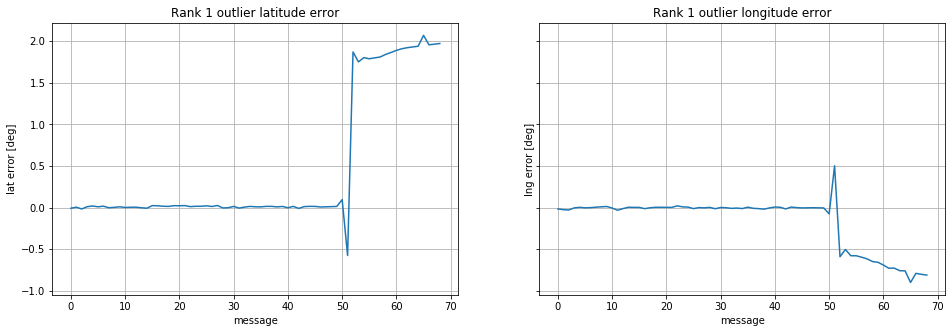

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
error_lat = model_lat.predict(df_feat_red.loc[outlier1MessId]) - outlier1y[:,0]
axes[0].plot(error_lat)
axes[0].set_title('Rank 1 outlier latitude error')
axes[0].set_xlabel('message')
axes[0].set_ylabel('lat error [deg]')
axes[0].grid()
error_lng = model_lng.predict(df_feat_red.loc[outlier1MessId]) - outlier1y[:,1]
axes[1].plot(error_lng)
axes[1].set_title('Rank 1 outlier longitude error')
axes[1].set_xlabel('message')
axes[1].set_ylabel('lng error [deg]')
axes[1].grid()

In [41]:
df_feat_red.loc[outlier1MessId][50:]

,,pivot_lat,pivot_lng,bs0_deltalat,bs0_deltalng,bs0_rssi,bs1_deltalat,bs1_deltalng,bs1_rssi,bs2_deltalat,bs2_deltalng,bs2_rssi,bs3_deltalat,bs3_deltalng,bs3_rssi,bs4_deltalat,bs4_deltalng,bs4_rssi
messid,,,,,,,,,,,,,,,,,,
57caac10cf554f22dc98a7bc,0,39.727714,-104.962679,-0.050463,0.009959,-117.000000,-0.025747,0.085815,-129.0,0.080201,-0.13518,-129.0,-0.008179,0.037977,-137.0,0.0,0.0,-1000.0
57cab3e6e541cd01b3916b53,0,39.364435,-104.888417,0.098079,-0.021497,-126.000000,-0.096547,0.021161,-128.0,0.000000,0.00000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0
57cf60bae541cd01b3a7c341,0,36.528704,-102.631195,0.000000,0.000000,-125.000000,0.000000,0.000000,-1000.0,0.000000,0.00000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0
57cf634de541cd01b3a96177,0,36.528704,-102.631195,0.000000,0.000000,-129.000000,0.000000,0.000000,-1000.0,0.000000,0.00000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0
57cf6b24e541cd01b3ae6cd8,0,36.528704,-102.631195,0.000000,0.000000,-127.333333,0.000000,0.000000,-1000.0,0.000000,0.00000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0
57cf6dc5cf554f22dcbe4c71,0,36.528704,-102.631195,0.000000,0.000000,-130.000000,0.000000,0.000000,-1000.0,0.000000,0.00000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0
57cf705fcf554f22dcbff061,0,36.528704,-102.631195,0.000000,0.000000,-135.000000,0.000000,0.000000,-1000.0,0.000000,0.00000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0
57cf72ff12f1437531e332ec,0,36.528704,-102.631195,0.000000,0.000000,-136.000000,0.000000,0.000000,-1000.0,0.000000,0.00000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0
57cf759ee541cd01b3b5923f,0,36.528704,-102.631195,0.000000,0.000000,-137.000000,0.000000,0.000000,-1000.0,0.000000,0.00000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0


Les 17 derniers messages n'ont qu'une seule BS et le device s'éloigne de la BS.

Ils sont affichés en bleu sur la carte suivante, au sud de Denver. Les BS, de tous les messages de ce device, sont en rouge.

In [42]:
m = folium.Map(
    location=[39.8, -105.0],
    zoom_start=6,
    tiles='Stamen Terrain'
)

for r in outlier1X.iterrows():
    row = r[1]
    folium.Circle(
        radius=max(5, 200+row['rssi']),
        location=[row['bs_lat'], row['bs_lng']],
        #popup='The Waterfront',
        color='crimson',
        fill=False,
    ).add_to(m)
 
for row in outlier1y[52:]:
    #row = r[1]
    folium.Circle(
        radius=10,
        location=[row[0], row[1]],
        #popup='The Waterfront',
        color='blue',
        fill=False,
    ).add_to(m)

m

## Construct test prediction

In [43]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [45]:
df_feat_test = feat_mat_const(df_mess_test, listOfBs)
df_feat.shape, df_feat_test.shape

((6068, 18), (5294, 18))

In [ ]:
y_pred_test_lat, y_pred_test_lng, reg = regressor_and_predict(df_feat, ground_truth_lat, 
                                                    ground_truth_lng, df_feat_test, False)

In [ ]:
test_res = pd.DataFrame(np.array([y_pred_test_lat, y_pred_test_lng]).T, columns = ['lat', 'lng'])
test_res = pd.concat([df_mess_test['messid'], test_res], axis=1)

In [ ]:
test_res.head()

In [ ]:
test_res.to_csv('pred_pos_test_list.csv', index=False)